In [ ]:
# uncomment for running in colab

# from google.colab import drive
# drive.mount("/content/drive")
# %cd /content/drive/MyDrive/noncausal-transformer/

In [1]:
from contextlib import nullcontext
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from model import DecoderTransformerStack, DecoderTransformerConfig
from icl_data import LinearGenerator

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

context = nullcontext() if device == "mps" else torch.autocast(device)

print(f"using {device} device")

using cuda device


In [2]:
OUT_DIR = "out"

MAX_ITERS = 2000
EVAL_INTERVAL = 50

BLOCK_SIZE = 256
BATCH_SIZE = 128

MIN_LR = 1e-4
MAX_LR = 1e-5
WARMUP_ITERS = MAX_ITERS // 100
LR_DECAY_ITERS = MAX_ITERS - WARMUP_ITERS

In [3]:
model_architectures = {
    "tiny": {
        "n_embd": 64,
        "n_layer": 3,
        "n_head": 2,
    },
    "small": {
        "n_embd": 128,
        "n_layer": 6,
        "n_head": 4,
    },
    "standard": {
        "n_embd": 256,
        "n_layer": 12,
        "n_head": 8,
    }
}

In [4]:
model_architecture = model_architectures["tiny"]

causal_config = DecoderTransformerConfig(
    block_size=BLOCK_SIZE,
    n_layer=model_architecture["n_layer"],
    n_head=model_architecture["n_head"],
    n_embd=model_architecture["n_embd"],
    is_causal=True,
    loss_fn=F.mse_loss,
)

noncausal_config = DecoderTransformerConfig(
    block_size=BLOCK_SIZE,
    n_layer=model_architecture["n_layer"],
    n_head=model_architecture["n_head"],
    n_embd=model_architecture["n_embd"],
    is_causal=False,
    loss_fn=F.mse_loss,
)

In [5]:
data_generator = LinearGenerator(model_architecture["n_embd"], model_architecture["n_embd"])

In [6]:
def get_lr(iter_num: int) -> float:
    if iter_num < WARMUP_ITERS:
        return MAX_LR * iter_num / WARMUP_ITERS
    
    if iter_num > LR_DECAY_ITERS:
        return MIN_LR
    
    decay_ratio = (iter_num - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    assert 0 <= decay_ratio and decay_ratio <= 1
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return MIN_LR + coeff * (MAX_LR - MIN_LR)

In [7]:
causal_model = DecoderTransformerStack(causal_config).to(device)
noncausal_model = DecoderTransformerStack(noncausal_config).to(device)

with torch.no_grad():
    for (n1, p1), (n2, p2) in zip(
        causal_model.named_parameters(), 
        noncausal_model.named_parameters(),
    ):
        assert n1 == n2
        p1.copy_(p2)

In [8]:
causal_optimizer = causal_model.configure_optimizers(weight_decay=0.1, learning_rate=MIN_LR, 
                                                     betas=(0.9, 0.99), device_type=device)

noncausal_optimizer = noncausal_model.configure_optimizers(weight_decay=0.1, learning_rate=MIN_LR, 
                                                           betas=(0.9, 0.99), device_type=device)

In [9]:
models_and_optimizers = [(causal_model, causal_optimizer), (noncausal_model, noncausal_optimizer)]
losses = [[], []]

In [10]:
t0 = time.time()
forward_idxs = [i for i in range(BLOCK_SIZE) if i % 2 == 1]

for i in range(MAX_ITERS):
    data = data_generator.generate_batch(BATCH_SIZE, BLOCK_SIZE // 2).to(device)
    x = data[:, :-1, :]
    y = data[:, 1:, :]
    
    lr = get_lr(i)
    for k, (model, optimizer) in enumerate(models_and_optimizers):
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        
        with context:
            _, loss = model(x, y, backward=True, forward_idxs=forward_idxs)

        optimizer.step()
        optimizer.zero_grad()

        losses[k].append(loss.detach().cpu())
    
    if (i + 1) % EVAL_INTERVAL == 0:
        dt = time.time() - t0
        t0 = time.time()
        print(f"{f'[{i + 1}]':8}", end="")
        print(f"causal loss: {np.mean(losses[0][-EVAL_INTERVAL:]):.3f}", end=", ")
        print(f"noncausal loss: {np.mean(losses[1][-EVAL_INTERVAL:]):.3f}", end=", ")
        print(f"time: {dt:.1f}s")
    
    i += 1

[50]    causal loss: 65.951, noncausal loss: 65.951, time: 80.0s
[100]   causal loss: 65.870, noncausal loss: 65.870, time: 78.1s
[150]   causal loss: 65.805, noncausal loss: 65.805, time: 77.8s
[200]   causal loss: 65.747, noncausal loss: 65.748, time: 77.7s
[250]   causal loss: 65.692, noncausal loss: 65.693, time: 78.2s
[300]   causal loss: 65.562, noncausal loss: 65.564, time: 78.2s
[350]   causal loss: 65.443, noncausal loss: 65.445, time: 78.4s
[400]   causal loss: 65.296, noncausal loss: 65.298, time: 78.5s
[450]   causal loss: 65.135, noncausal loss: 65.138, time: 78.5s
[500]   causal loss: 65.005, noncausal loss: 65.009, time: 78.3s
[550]   causal loss: 64.748, noncausal loss: 64.753, time: 78.2s
[600]   causal loss: 64.469, noncausal loss: 64.475, time: 78.2s
[650]   causal loss: 64.076, noncausal loss: 64.085, time: 78.2s
[700]   causal loss: 63.716, noncausal loss: 63.727, time: 78.3s
[750]   causal loss: 63.244, noncausal loss: 63.260, time: 78.0s
[800]   causal loss: 62.6

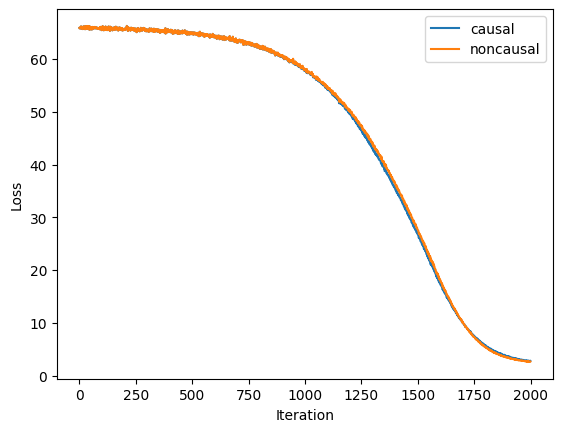

In [11]:
plt.plot(losses[0], label="causal")
plt.plot(losses[1], label="noncausal")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()